In [1]:
using ITensors
import KrylovKit 
#using KrylovKit
include("TamaTimeEvoMPS/src/TimeEvoMPS.jl")
using .TimeEvoMPS

In [2]:
using DelimitedFiles
coups = readdlm("WSCP_MC_T0_coups.dat");
freqs = readdlm("WSCP_MC_T0_freqs.dat");
#system energy gap
eps = 138.

138.0

In [3]:
sys = siteinds("S=1/2",1);
NChain = 150;
env = siteinds("Boson", dim=6, NChain);
NN = NChain + 1;
sysenv = vcat(sys,env);

In [4]:
stateSys = ["Up"];
stateEnv = ["0" for n=1:NChain];
stateSE = vcat(stateSys,stateEnv);
psi0 = productMPS(sysenv,stateSE);

In [5]:
size(sysenv)[1]

151

In [6]:
ampo = OpSum()
#system Hamiltonian
ampo += eps,"Sz",1;
#system-env interaction
#!Sx = 0.5 σx
ampo += coups[1],"Sx",1,"Adag",2
ampo += coups[1],"Sx",1,"A",2
#chain local Hamiltonians
for j=2:NChain
   ampo += freqs[j-1],"N",j
end

for j=2:NChain-1
   ampo += coups[j],"A",j,"Adag",j+1
   ampo += coups[j],"Adag",j,"A",j+1
end
H = MPO(ampo,sysenv); 

In [66]:
H[2]

ITensor ord=4 (dim=3|id=710|"Link,l=1") (dim=4|id=548|"Link,l=2") (dim=6|id=944|"Boson,Site,n=1")' (dim=6|id=944|"Boson,Site,n=1")
ITensors.NDTensors.Dense{Float64, Vector{Float64}}

In [7]:
appo=opPos("Sx",1)
vobs = []
push!(vobs,appo)
push!(vobs,opPos("Sz",1))
push!(vobs,opPos("N",10))
push!(vobs,opPos("N",40))
push!(vobs,opPos("N",80))

5-element Vector{Any}:
 opPos("Sx", 1)
 opPos("Sz", 1)
 opPos("N", 10)
 opPos("N", 40)
 opPos("N", 80)

In [8]:
psi = psi0;
appo = Float64[]
for lookat in vobs
   orthogonalize!(psi,lookat.pos); 
   psidag = dag(prime(psi[lookat.pos],"Site"));
   m=scalar(psidag*op(sysenv,lookat.op,lookat.pos)*psi[lookat.pos])
   push!(appo,m);  
end
appo

5-element Vector{Float64}:
 0.0
 0.5
 0.0
 0.0
 0.0

In [67]:
timestep = 0.0001
cbT = LocalMeasurementCallbackTama(vobs,sysenv,timestep)

LocalMeasurementCallback
Operators: opPos[opPos("Sx", 1), opPos("Sz", 1), opPos("N", 10), opPos("N", 40), opPos("N", 80)]
No measurements performed


In [68]:
tdvp!(psi,H,0.0001,0.0004,maxdim=20,callback=cbT, progress=true)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /Users/tama/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Evolving state... 100%|█████████████████████████████████| Time: 0:05:18
  t:             0.0004
  dt step time:  80.994
  Max bond-dim:  20


In [15]:
res = measurements(cbT)

Dict{String, Vector{Vector{Float64}}} with 5 entries:
  "N_40" => [[1.24507e-19], [1.23881e-19], [1.27953e-19], [1.224e-19]]
  "Sx_1" => [[1.96436e-15], [1.88757e-15], [1.81119e-15], [1.73572e-15]]
  "Sz_1" => [[0.499593], [0.499415], [0.499204], [0.498961]]
  "N_10" => [[1.32041e-16], [8.52086e-17], [1.33255e-16], [8.64516e-17]]
  "N_80" => [[9.29883e-20], [9.07319e-20], [9.03469e-20], [8.85229e-20]]

In [75]:
using LinearAlgebra
BLAS.vendor()

:openblas64

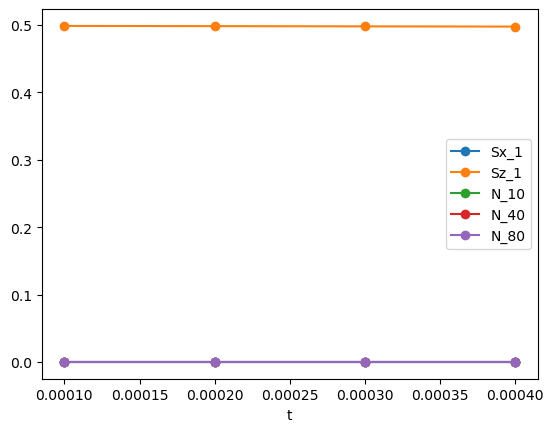

PyObject Text(0.5, 24.0, 't')

In [71]:
using PyPlot
ts = measurement_ts(cbT)
for o in ["Sx_1","Sz_1","N_10","N_40","N_80"]
    S5 = getindex.(measurements(cbT)["$o"],1)
    plot(ts,S5,"-o",label="$o")
end
legend()
xlabel("t")

In [14]:
norm(psi)

1.0